In [30]:
import json
from lit_llama.tokenizer import Tokenizer
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

In [18]:
output_raw_json_path = "/cluster/home/repo/my_llm_experiments/lit-llama/esrs_finetune/esrs_alpaca_raw.json"
tokenizer_path = "/cluster/home/repo/my_llm_experiments/lit-llama/checkpoints/lit-llama/tokenizer.model"
IGNORE_INDEX = -1

In [3]:
with open(output_raw_json_path, "r") as file:
        data = json.load(file)

In [11]:
tokenizer = Tokenizer(tokenizer_path)

In [24]:
def tokenize(tokenizer: Tokenizer, string: str, max_length: int, eos=True) -> torch.Tensor:
    # return tokenizer.encode(string, bos=True, eos=eos, max_length=max_length)
    return tokenizer.encode(string, bos=True, eos=eos)


def prepare_sample(example: dict, tokenizer: Tokenizer, max_length: int, mask_inputs: bool = True):
    prompt_reponse_fmt = " > ".join([f"[{idx}]" for idx, _ in enumerate(example['paragraphs'])])

    full_prompt = generate_prompt(example)
    full_prompt_and_response = full_prompt + f"Response: {prompt_reponse_fmt}"
    encoded_full_prompt = tokenize(tokenizer, full_prompt, max_length=max_length, eos=False)
    encoded_full_prompt_and_response = tokenize(tokenizer, full_prompt_and_response, eos=True, max_length=max_length)

    # The labels are the full prompt with response, but with the prompt masked out
    labels = encoded_full_prompt_and_response.clone()
    if mask_inputs:
        labels[:len(encoded_full_prompt)] = IGNORE_INDEX

    return {**example, "input_ids": encoded_full_prompt_and_response, "input_ids_no_response": encoded_full_prompt, "labels": labels}

def generate_prompt(example):
    """Generates a standardized message to prompt the model with an instruction, optional input and a
    'response' field."""

    system_message = """
    As an expert in sustainability reports and the new CSRD directive, 
    your task is to identify relevant paragraph ids from a list of given
    paragraphs based on a given regulatory requirement and its sub-requirement.
    Rank the 2 passages below based on their
    relevance to the Requirement and Sub-Requirement. All the passages
    should be included and listed using identifiers, in
    descending order of relevance. The output format
    should be [] > [], e.g., [4] > [2]. Only respond
    with the ranking results, do not say any word
    or explain.
    """

    input_message = """
    Requirement: "{section_name}"
    Sub-Requirement: "{compliance_item_name}"
    Paragraphs:
    {paragraphs}
    """
    relevant_paragraphs = "\n\n".join([f"\n[{i}]: \"{paragraph}\"" 
                            for i, paragraph in enumerate(example['paragraphs'])])
    return f"""
    USER: {system_message}
    {input_message.format(
        section_name=example['section_name'],
        compliance_item_name=example['compliance_item_name'],
        paragraphs=relevant_paragraphs
    )}
    {relevant_paragraphs}
    """

In [36]:
prompt_lengths = [len(prepare_sample(sample, tokenizer, max_length= 256)['input_ids']) for sample in tqdm(data, desc="Processing prompts")]

Processing prompts: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189351/189351 [25:55<00:00, 121.72it/s]


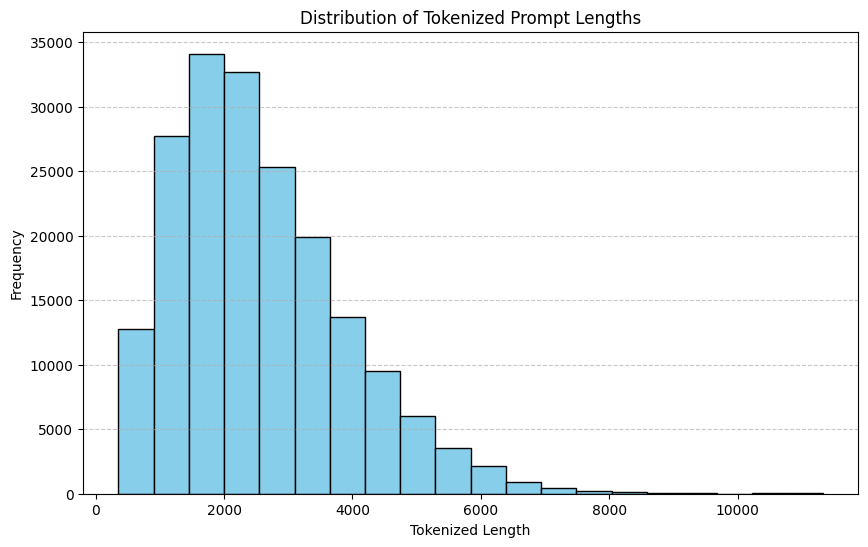

In [37]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.hist(prompt_lengths, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Tokenized Length')
plt.ylabel('Frequency')
plt.title('Distribution of Tokenized Prompt Lengths')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [38]:
max(prompt_lengths)

11330

In [44]:
print(data[0]['paragraphs'][0])

2022
2021
2020(5)
Fuel consumption (petrol and diesel) in litres
320,923
279,403
316,602
Fuel consumption per company vehicle in litres(2)
1,283.7
1,214.8
1,486.4
Total kilometres travelled(3)
5,140,134
3,730,403
4,560,813
Kilometres travelled per company vehicle
20,560
16,219
21,412
CO2 equivalents in tonnes(4) (Scope 1)
839.2
730.9
829.2
